### Linear regression from scratch using OLS

In [1153]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import copy
import seaborn as sns
from sklearn.model_selection import train_test_split

In [1154]:
train_data=pd.read_csv('/Users/pushpakumar/Downloads/cs-215-assignment-3-multiple-variate-regression/train.csv')
# test_data=pd.read_csv('/Users/pushpakumar/Downloads/cs-215-assignment-3-multiple-variate-regression/test.csv')

In [1155]:
train_corr=train_data.corr()
target = 'yield'
correlation_with_target = train_corr[target]

low_corr_threshold = 0.2
low_corr_features = correlation_with_target[abs(correlation_with_target) < low_corr_threshold].index.tolist()

high_corr_threshold=0.6
high_corr_features = correlation_with_target[abs(correlation_with_target) > high_corr_threshold].index.tolist()

train_data = train_data.drop(columns=low_corr_features)
x= train_data.drop(columns='yield').values
y = train_data['yield'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0)

In [1156]:
# Visualize the data using scatter plot and histogram
# sns.set_palette('colorblind')
# sns.pairplot(data=train_data)

In [1157]:

class Multiple_linear_regression():
    def __init__(self):
        self.coefficients=None
        self.intercept=None
        
    def fit(self,x,y):
        x=self.transform_x(x)
        y=self.transform_y(y)
        betas=self.estimate_coefficients(x,y)
        self.intercept=betas[0]
        self.coefficients=betas[1:]
        
    def predict(self, x):
        ## y = b_0 + b_1*x + ... + b_i*x_i
        prediction = np.dot(x, self.coefficients) + self.intercept
        return prediction
    
    def r2_score(self, y_true, y_pred):
        '''
            r2 = 1 - (rss/tss)
            rss = sum_{i=0}^{n} (y_i - y_hat)^2
            tss = sum_{i=0}^{n} (y_i - y_bar)^2
        '''
        y_values=y_true
        y_avg=np.mean(y_values)
        
        residual_sum_of_squares=0
        total_sum_of_squares=0
        for i in range(len(y_values)):
            residual_sum_of_squares+=(y_values[i]-y_pred[i])**2
            total_sum_of_squares+=(y_values[i]-y_avg)**2
            
        return 1-(residual_sum_of_squares/total_sum_of_squares)
    
    def transform_x(self, x):
        return np.hstack((np.ones((x.shape[0], 1)), x))
    def transform_y(self,y):
        return y
    def estimate_coefficients(self,x,y):
        # (x'x)^-1 x'y 
        xT=x.transpose()
        inversed=np.linalg.inv(xT.dot(x))
        coefficients=inversed.dot(xT).dot(y) 
        return coefficients

In [1158]:
class Nadaraya_watson_kernel_guassian():
    def __init__(self,bandwidth=1.0):
        self.bandwidth=bandwidth
        self.x_data=None
        self.y_data=None
    def fit(self,x,y):
        self.x_data=np.array(x)
        self.y_data=np.array(y)
    def gaussian_kernel(self,x):
        ## (1/2*pi) e^{-x^2 / 2}
        exponent=np.exp(-0.5 * (x**2))
        result=exponent/np.sqrt(2*np.pi)
        return result
    
    def predict(self, x):
        temp = (x - self.x_data) / self.bandwidth
        distance_from_origin=np.linalg.norm(temp,axis=1)
        ker = self.gaussian_kernel(distance_from_origin)
        num = np.sum(ker * self.y_data)
        den = np.sum(ker)
        return num / den           
    
    def risk_function(self, x, y):
        # x is prediction y is actual 
        return np.mean((x-y)**2)

In [1159]:
def mean_absolute_error(x,y):
    n=len(x)
    error=0
    for i in range(n):
        error+=abs(x[i]-y[i])
    return error/n

In [1160]:
class predict_data():
    def __init__(self,x,y,z):
        self.x_train=x
        self.y_train=y
        self.x_test=z
        
    def train(self):
        self._train_mlr()
        self._train_kr()
    
    def test(self):
        self.prediction_mlr_test=self.mlr.predict(self.x_test)
        self.prediction_kr_test=[]
        for i in range(len(self.x_test)):
            temp=self.kr.predict(self.x_test[i])
            self.prediction_kr_test.append(temp)
            
    def prediction(self):
        self.train()
        self.test()
        
        self.prediction_mlr_test=np.array(self.prediction_mlr_test)
        self.prediction_kr_test=np.array(self.prediction_kr_test)
        self.x_train_final = np.column_stack((self.prediction_mlr, self.prediction_kr))
        self.y_train_final=self.y_train
        self.x_test_final = np.column_stack((self.prediction_mlr_test, self.prediction_kr_test))
        
        self.mix_kr=Nadaraya_watson_kernel_guassian(117.17171717171718)
        self.mix_kr.fit(self.x_train_final,self.y_train_final)
        self.predict_final=[]
        for j in range(len(self.x_test_final)):
            temp=self.mix_kr.predict(self.x_test_final[j])
            self.predict_final.append(temp)
        return self.predict_final
    
    def _train_mlr(self):
        self.mlr=Multiple_linear_regression()
        self.mlr.fit(self.x_train,self.y_train)
        self.prediction_mlr=self.mlr.predict(self.x_train)
        self.MAE_mlr=mean_absolute_error(self.prediction_mlr,self.y_train)
        
    def _train_kr(self,bandwidth=0.135678391959799):
        self.bandwidth=bandwidth
        self.kr=Nadaraya_watson_kernel_guassian(self.bandwidth)
        self.kr.fit(self.x_train,self.y_train)
        self.prediction_kr=[]
        for i in range(len(self.x_train)):
            temp=self.kr.predict(self.x_train[i])
            self.prediction_kr.append(temp)
        self.MAE_kr=mean_absolute_error(self.prediction_kr,y_train)

In [1161]:
res=predict_data(x_train,y_train,x_test)

In [1162]:
final=res.prediction()

In [1163]:
print(final)

[7114.0849967060885, 5554.156104810803, 8247.263273433375, 6226.226868600415, 6103.114375075579, 7390.571149043466, 5716.044286540226, 6743.7449187095945, 6868.718753697491, 7169.414143681546, 7365.516513225814, 5008.097596244916, 5549.223518385835, 5148.902557597275, 7315.146579199252, 7363.034138262653, 3875.237090054442, 3102.0007288314036, 5512.327541881488, 5228.690645548763, 6917.630304788921, 6661.987188948508, 6641.549111486332, 6565.780584033357, 4272.15806813737, 7807.817636810312, 6439.0647354827015, 5748.031626569263, 7429.551302314986, 8442.343656020388, 6617.127634082119, 3190.5491927364615, 5632.098863129785, 6573.476230272697, 2722.1612311172494, 6004.967354913683, 6501.002357317088, 6172.402864708049, 6655.675876827712, 4217.201999018257, 5122.682529558868, 4860.5044880955575, 4820.062209846204, 8206.209576184649, 8360.711949415569, 7328.614181471117, 7167.268002147685, 8244.675506595446, 7205.657053886715, 4061.6102491952115, 6885.228611793158, 3275.90237360211, 5281.

In [1164]:
print(mean_absolute_error(y_test,final))

241.338200659098


below 4 blocks for calculating optimal h for kr

In [1165]:
# x_train_h, x_test_h, y_train_h, y_test_h = train_test_split(x_train, y_train, test_size=0.1, random_state=0)

In [1166]:
# print(x_train_h.shape)

(12150, 7)


/var/folders/hz/gjlv0lbd4ds7shs1th30424c0000gp/T/ipykernel_16471/4280900310.py:16: RuntimeWarning: divide by zero encountered in divide
  temp = (x - self.x_data) / self.bandwidth
/var/folders/hz/gjlv0lbd4ds7shs1th30424c0000gp/T/ipykernel_16471/4280900310.py:16: RuntimeWarning: invalid value encountered in divide
  temp = (x - self.x_data) / self.bandwidth
/var/folders/hz/gjlv0lbd4ds7shs1th30424c0000gp/T/ipykernel_16471/4280900310.py:21: RuntimeWarning: invalid value encountered in scalar divide
  return num / den


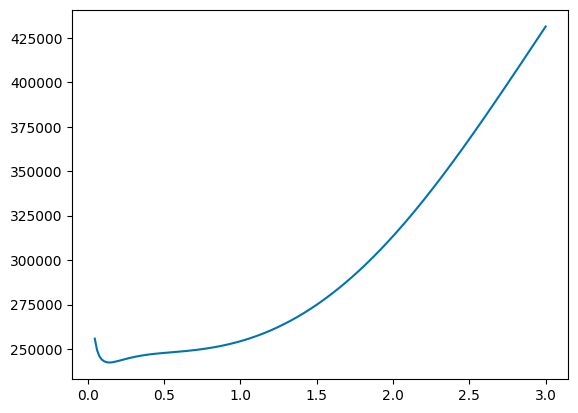

In [1167]:
# h_x=np.linspace(0,3,200)
# risk=[]
# for i in h_x:
#     a=Nadaraya_watson_kernel_guassian(i)
#     a.fit(x_train_h,y_train_h)
#     pred=[]
#     for j in range(len(x_test_h)):
#         temp=a.predict(x_test_h[j])
#         pred.append(temp)
#     risk.append(a.risk_function(pred,y_test_h))
# plt.plot(h_x,risk)

In [1168]:
# risk=np.array(risk)
# risk_witout_nan=risk[~np.isnan(risk)]
# print(risk_witout_nan.min())
# index = np.where(risk== risk_witout_nan.min())[0][0]
# print(index)
# h=h_x[index]
# print(h)

242408.54145124555
9
0.135678391959799


In [1169]:
# kr=Nadaraya_watson_kernel_guassian(0.135678391959799)
# kr.fit(x_train,y_train)
# prediction_kr=[]
# for i in range(len(x_train)):
#     temp=kr.predict(x_train[i])
#     prediction_kr.append(temp)
    
# print(prediction_kr[0:15])

# print(y_train[0:15])

[4024.5497496603134, 7603.192492412129, 7758.580765634257, 6626.944810021594, 7565.354717019368, 3841.300093600164, 6103.307424852618, 6808.04716211552, 5283.383814021644, 5664.907146368641, 4219.51266234258, 6810.934083316312, 3771.826333267558, 4461.617561822865, 7117.281646662299]
[4125.75712 7423.46988 8969.40184 6226.28514 7778.34916 4952.9856
 5739.92493 6771.72291 4926.27902 2508.37567 3923.90628 7007.66825
 4225.96131 4232.76231 7415.89441]


In [1170]:
# print(mean_absolute_error(y_train,prediction_kr))

326.6543262139526


below 4 blocks for finding best h for mixed data 

/var/folders/hz/gjlv0lbd4ds7shs1th30424c0000gp/T/ipykernel_16471/4280900310.py:16: RuntimeWarning: divide by zero encountered in divide
  temp = (x - self.x_data) / self.bandwidth
/var/folders/hz/gjlv0lbd4ds7shs1th30424c0000gp/T/ipykernel_16471/4280900310.py:21: RuntimeWarning: invalid value encountered in scalar divide
  return num / den
/var/folders/hz/gjlv0lbd4ds7shs1th30424c0000gp/T/ipykernel_16471/4280900310.py:16: RuntimeWarning: invalid value encountered in divide
  temp = (x - self.x_data) / self.bandwidth


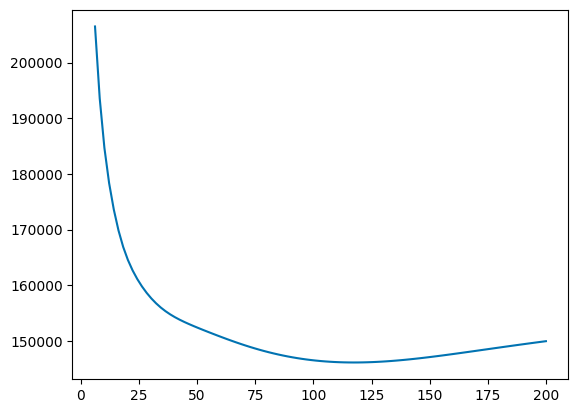

In [1171]:
# aa=res.prediction_mlr
# bb=res.prediction_kr

# x_train_final = np.column_stack((aa, bb))
# y_train_final=res.y_train

# cc=res.prediction_mlr_test
# dd=res.prediction_kr_test

# x_test_final=np.column_stack((cc, dd))
# y_test_final=y_test
# x_train_f, x_test_f, y_train_f, y_test_f = train_test_split(x_train_final, y_train_final, test_size=0.1, random_state=0)

# h_x=np.linspace(0,200,100)
# risk=[]
# for i in h_x:
#     a=Nadaraya_watson_kernel_guassian(i)
#     a.fit(x_train_f,y_train_f)
#     pred=[]
#     for j in range(len(x_test_f)):
#         temp=a.predict(x_test_f[j])
#         pred.append(temp)
#     risk.append(a.risk_function(pred,y_test_f))
# plt.plot(h_x,risk)
    


In [1172]:
# risk=np.array(risk)
# risk_witout_nan=risk[~np.isnan(risk)]
# print(risk_witout_nan.min())
# index = np.where(risk== risk_witout_nan.min())[0][0]
# print(index)
# h=h_x[index]
# print(h)

146157.49119589268
58
117.17171717171718


In [1173]:
# xx=Nadaraya_watson_kernel_guassian(117.17171717171718)
# xx.fit(x_train_final,y_train_final)
# pred=[]
# for j in range(len(x_test_final)):
#     temp=xx.predict(x_test_final[j])
#     pred.append(temp)

In [1174]:
# print(mean_absolute_error(pred,y_test_final))

239.89853219006537
